In [118]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import czifile as czi
from openpiv import tools, pyprocess, validation

# Local import
from points_df import Points

## Data Loading

We start by selecting the appropriate parameters. Given the exploratory analysis in `data_exploration.ipynb`, the ideal window size in our case is between 8 and 32, balancing granularity with sparsity. The search size we choose ~2x as large. Ideally, this is the window size plus the expected maximum number of pixels a point would move, but choosing anything larger than this will work. The overlap specifies how much the template window (window size) and search window can overlap. Finally, dt gives the timestep in between frames. Since the video was taken at 10FPS, one frame time is 0.1 seconds.

In [119]:
opiv_window_size = 16
opiv_search_size = 20
opiv_overlap = 8
opiv_dt = 0.1

Next, we define the experiment that we will be using. In this case, it will be `220530-E1_Out`.

In [120]:
experiment = '220530-E1_Out'

We now read the image data for this experiment. The result is an $n$-dimensional TIFF file with dimensions for the color channels, spatial x and y dimensions and the temporal dimension (z or t).

In [121]:
# Reading in the image from the associated experiment
image_dir = '../data/ablation-czi/' + experiment + '.czi'

with czi.CziFile(image_dir) as image_czi:
    # Read the image data from the CZI file
    image_data = image_czi.asarray()

image_data.shape

(1, 1, 2, 115, 1, 512, 512, 1)

Some data processing to get the color channel data into a numpy array.

In [122]:
# Preparation for visual plotting
channel_red   = np.squeeze(image_data[:, :, 0, :, :, :, :, :])
channel_green = np.squeeze(image_data[:, :, 1, :, :, :, :, :])

# Normalize for visualization 
channel_red_norm    = channel_red / channel_red.max()
channel_green_norm  = channel_green / channel_green.max()

# Create RG(B) stack for each slice
num_slices = channel_red_norm.shape[0]
rgb_stack = np.zeros((num_slices, 512, 512, 2), dtype=np.float32)
rgb_stack[..., 0] = channel_red_norm    # Red
rgb_stack[..., 1] = channel_green_norm  # Green

## Obtaining the velocity map with OpenPIV

Next we can infer the velocities between two frames given the settings and the image data using OpenPIV. For this, we select two frame indices and the implementation will try to infer the velocities of the points between the frames. From the `rgb_stack`, we choose a random color channel, in this case the RED channel.

In [123]:
frame_index_a = 3
frame_index_b = 4

frame_a_fl = rgb_stack[frame_index_a][..., 0]
frame_b_fl = rgb_stack[frame_index_b][..., 0]

We wrangle the data to be in an integer format between 0 and 255 (currently, the values are stored as floating point numbers between 0 and 1)

In [124]:
frame_a = (frame_a_fl * 255).astype(np.uint32)
frame_b = (frame_b_fl * 255).astype(np.uint32)

We then utilize the OpenPIV implementation to obtain the velocities.

In [125]:
vel_x, vel_y, signal_to_noise = pyprocess.extended_search_area_piv(
    frame_a,
    frame_b,
    window_size     = opiv_window_size,
    overlap         = opiv_overlap,
    dt              = opiv_dt,
    search_area_size= opiv_search_size,
    sig2noise_method='peak2peak'
)

We can obtain the coordinates of the velocity vectors.

In [126]:
x, y = pyprocess.get_coordinates(
    image_size      = frame_a.shape,
    search_area_size= opiv_search_size,
    overlap         = opiv_overlap
)

We can now extract the vectors that have a magnitude large enough compared to the noise ratio. We can first inspect the signal-to-noise ratios.

In [127]:
#plt.hist(signal_to_noise.flatten())

We will filter with a threshold of 1.

In [128]:
vel_x, vel_y, invalid_mask = validation.sig2noise_val(
    vel_x, 
    vel_y,
    signal_to_noise, 
    threshold=1.0
)

Some transform the velocities to be at the propper positions before plotting.

In [129]:
x, y, vel_x, vel_y = tools.transform_coordinates(x, y, vel_x, vel_y)

Finally, we save the original template frame to a BMP file. This is necessary because OpenPIV doesn't accept TIFF files and requires a file path instead of an image object when overlaying an image.

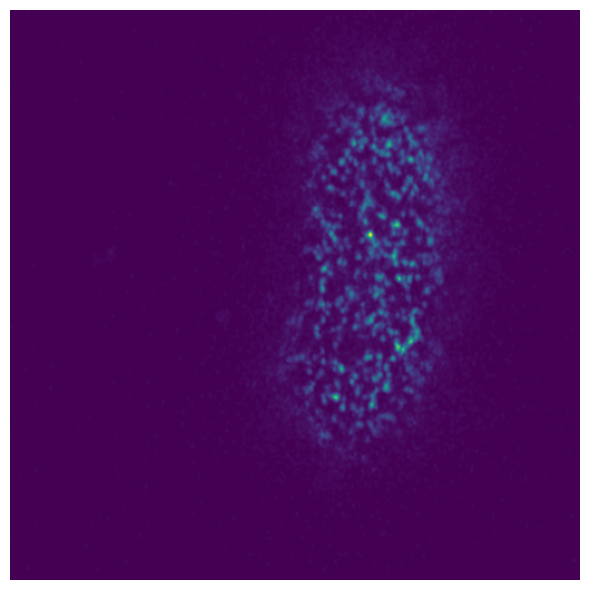

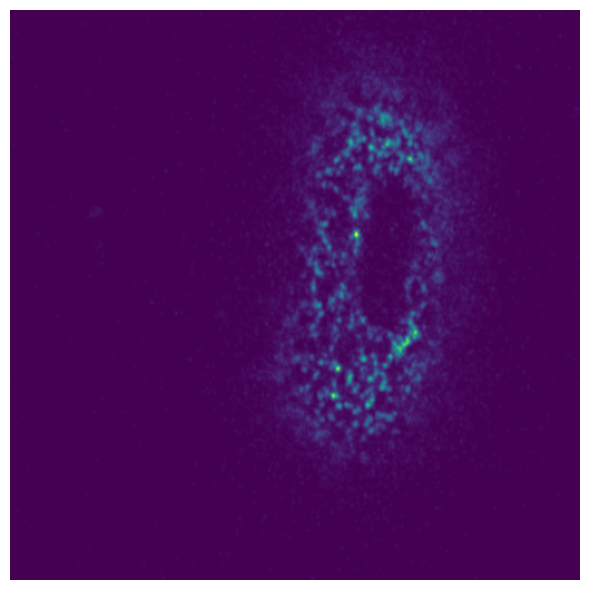

In [130]:
def visualize(data: np.ndarray, title: str = None, path: str = None):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))

    ax.imshow(data, cmap='viridis')
    if title:
        ax.set_title(title)
    ax.axis('off')

    plt.tight_layout()
    plt.show()

    # Save the image if a path is provided
    if path:
        fig.savefig(path, format='png', dpi=300, pad_inches=0)

visualize(frame_a, title=None, path='opiv_template.png')
visualize(frame_b, title=None, path='opiv_search.png')

Before visualizing, we must save the velocity field in ASCII format.

In [131]:
tools.save(x, y, vel_x, vel_y, invalid_mask, 'opiv_template_velocity.txt')

Finally, we can plot the velocity field onto the overlayed image. We could use the built-in plotting utilities in OpenPIV, but they make ugly figures and are hard to control. Rather, we create our own implementation. First, we replace all NaN values in the velocity with 0. Note; we do **NOT** normalize, since the result from OpenPIV gives us the number of pixels moved (in a specific dimension) in a frametime.

In [132]:
vel_x = np.nan_to_num(vel_x, 0)
vel_y = np.nan_to_num(vel_y, 0)

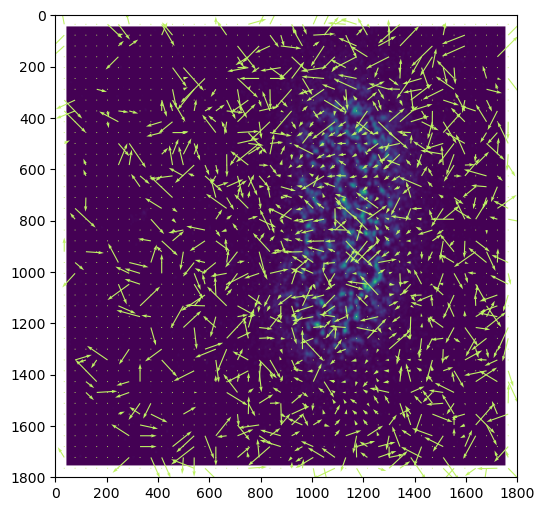

In [133]:
def visualize_velocity_field(frame_a, x, y, vel_x, vel_y, scale, overlay_path):
    # Load the background image
    img = mpimg.imread(overlay_path)
        
    img_width = img.shape[0]
    img_height = img.shape[1]

    spatial_scale_x = img_width / frame_a.shape[0]
    spatial_scale_y = img_height / frame_a.shape[1]

    x = x * spatial_scale_x
    y = y * spatial_scale_y

    # Create the plot
    plt.figure(figsize=(6, 6))
    plt.imshow(img, origin='upper')  # show image with origin at top-left

    # Ensure vel_x and vel_y are scaled
    vel_x_scaled = vel_x * scale
    vel_y_scaled = vel_y * scale

    # Plot velocity vectors
    plt.quiver(x, y, vel_x_scaled, vel_y_scaled, color='#bef264', angles='xy', scale_units='xy', scale=1)

    # Adjust plot limits to match the image
    plt.xlim(0, img.shape[1])
    plt.ylim(img.shape[0], 0)  # invert y-axis to match image coordinates
    plt.show()

visualize_velocity_field(frame_a, x, y, vel_x, vel_y, 1.0, 'opiv_template.png')

## OpenPIV benchmark

We can now benchmark OpenPIV against the the specific points in the manually annotated data. We will first load this data 

In [134]:
df = Points.from_csv('../out/points.csv')

We filter to our experiment and frame indices (i.e. time).

In [135]:
points_a = df.points_by_cell(experiment).points_by_frame(frame_index_a)
points_b = df.points_by_cell(experiment).points_by_frame(frame_index_b)
points_c = df.points_by_cell(experiment).points_by_frame(frame_index_b + 1)

In [136]:
points_a

,Unnamed: 0,point_id,cell_id,cut,frame,x,y,timestamp,x_pixel_size,y_pixel_size,...,frame_rel,x_parallel,x_perpendicular,cut_length,vx,vy,velocity,v_parallel,v_perpendicular,velocity_cut
0,0,0,220530-E1_Out,False,3,368.0,192.0,2731.228878,0.050355,0.050355,...,-1,0.781787,28.094557,93.434469,3.0,0.0,3.000000,0.003093,2.986050,2.986052
8,8,1,220530-E1_Out,False,3,306.0,251.0,2731.228878,0.050355,0.050355,...,-1,0.089347,-27.934017,93.434469,-9.0,-1.0,9.055385,0.001375,-9.054474,9.054474
16,16,2,220530-E1_Out,False,3,374.0,224.0,2731.228878,0.050355,0.050355,...,-1,0.447079,37.149031,93.434469,3.0,0.0,3.000000,0.003093,2.986050,2.986052
23,38,5,220530-E1_Out,False,3,315.0,188.0,2731.228878,0.050355,0.050355,...,-1,0.769759,-25.044291,93.434469,-5.0,-6.0,7.810250,0.058763,-5.554695,5.555006
31,46,6,220530-E1_Out,False,3,316.0,184.0,2731.228878,0.050355,0.050355,...,-1,0.813402,-24.434237,93.434469,-7.0,-2.0,7.280110,0.014089,-7.160098,7.160112


In [137]:
points_b

,Unnamed: 0,point_id,cell_id,cut,frame,x,y,timestamp,x_pixel_size,y_pixel_size,...,frame_rel,x_parallel,x_perpendicular,cut_length,vx,vy,velocity,v_parallel,v_perpendicular,velocity_cut
1,1,0,220530-E1_Out,False,4,371.0,192.0,2734.003849,0.050355,0.050355,...,0,0.784880,31.080607,93.434469,1.0,1.0,1.414214,-0.009622,1.091674,1.091717
9,9,1,220530-E1_Out,False,4,297.0,250.0,2734.003849,0.050355,0.050355,...,0,0.090722,-36.988491,93.434469,-2.0,0.0,2.000000,-0.002062,-1.990700,1.990701
17,17,2,220530-E1_Out,False,4,377.0,224.0,2734.003849,0.050355,0.050355,...,0,0.450172,40.135081,93.434469,1.0,0.0,1.000000,0.001031,0.995350,0.995351
24,39,5,220530-E1_Out,False,4,310.0,182.0,2734.003849,0.050355,0.050355,...,0,0.828522,-30.598986,93.434469,-1.0,-1.0,1.414214,0.009622,-1.091674,1.091717
32,47,6,220530-E1_Out,False,4,309.0,182.0,2734.003849,0.050355,0.050355,...,0,0.827491,-31.594336,93.434469,-2.0,-1.0,2.236068,0.008591,-2.087024,2.087042
41,56,7,220530-E1_Out,True,4,333.0,262.0,2734.003849,0.050355,0.050355,...,0,0.000000,0.000000,93.434469,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
points_c

,Unnamed: 0,point_id,cell_id,cut,frame,x,y,timestamp,x_pixel_size,y_pixel_size,...,frame_rel,x_parallel,x_perpendicular,cut_length,vx,vy,velocity,v_parallel,v_perpendicular,velocity_cut
2,2,0,220530-E1_Out,False,5,372.0,193.0,2734.999678,0.050355,0.050355,...,1,0.775258,32.172281,93.434469,2.0,1.0,2.236068,-0.008591,2.087024,2.087042
10,10,1,220530-E1_Out,False,5,295.0,250.0,2734.999678,0.050355,0.050355,...,1,0.088660,-38.979191,93.434469,-1.0,0.0,1.000000,-0.001031,-0.995350,0.995351
18,18,2,220530-E1_Out,False,5,378.0,224.0,2734.999678,0.050355,0.050355,...,1,0.451203,41.130431,93.434469,1.0,0.0,1.000000,0.001031,0.995350,0.995351
25,40,5,220530-E1_Out,False,5,309.0,181.0,2734.999678,0.050355,0.050355,...,1,0.838144,-31.690660,93.434469,-1.0,-1.0,1.414214,0.009622,-1.091674,1.091717
33,48,6,220530-E1_Out,False,5,307.0,181.0,2734.999678,0.050355,0.050355,...,1,0.836082,-33.681360,93.434469,-1.0,-2.0,2.236068,0.020275,-1.187998,1.188171


We keep only the points that have "survived", and thus filter on points whose `point_id` is present

In [139]:
points_a = points_a[points_a['point_id'].isin(points_b['point_id'])]
points_b = points_b[points_b['point_id'].isin(points_a['point_id'])]
points_c = points_c[points_c['point_id'].isin(points_b['point_id'])]

For all the points in `points_a`, we now compute their "expected position" based on the annotated velocity. We will call this the **ground truth** for now.

In [140]:
points_ax = points_a['x'].to_numpy()
points_ay = points_a['y'].to_numpy()

points_bx = points_b['x'].to_numpy()
points_by = points_b['y'].to_numpy()

points_cx = points_c['x'].to_numpy()
points_cy = points_c['y'].to_numpy()

In [141]:
frame_diff_ab = points_b['frame_rel'].to_numpy() - points_a['frame_rel'].to_numpy()
frame_diff_bc = points_c['frame_rel'].to_numpy() - points_b['frame_rel'].to_numpy()

gt_updated_ax = points_ax + frame_diff_ab * points_a['vx'].to_numpy()
gt_updated_ay = points_ay + frame_diff_ab * points_a['vy'].to_numpy()

gt_updated_bx = points_bx + frame_diff_bc * points_b['vx'].to_numpy()
gt_updated_by = points_by + frame_diff_bc * points_b['vy'].to_numpy()

gt_updated_ax

array([371., 297., 377., 310., 309.])

We can now predict the positions given the data from OpenPIV. One caveat is that we do not have a per-point velocity, rather a velocity grid. This means we will have to bilinearly interpolate between the four corner velocities.

In [142]:
# Use scipy for bilinear interpolation :)
from scipy.interpolate import RegularGridInterpolator

x_grid = x[0, :]
y_grid = y[:, 0]

vel_x_interp = RegularGridInterpolator((y_grid, x_grid), vel_x, bounds_error=False, fill_value=None)
vel_y_interp = RegularGridInterpolator((y_grid, x_grid), vel_y, bounds_error=False, fill_value=None)

ivel_x = [vel_x_interp((px, py)) for px, py in zip(points_ax, points_ay)]
ivel_y = [vel_y_interp((px, py)) for px, py in zip(points_ax, points_ay)]

Given the velocities in both x and y directions, we can predict the new positions.

In [143]:
predict_updated_x = points_ax + frame_diff_ab * ivel_x
predict_updated_y = points_ay + frame_diff_ab * ivel_y

predict_updated_x

array([353.75630272, 294.53348156, 389.77668094, 298.58671343,
       301.47920655])

In [144]:
def rmse(gt, prediction):
    return np.sqrt(np.mean((prediction - gt) ** 2))

rmse_x = rmse(gt_updated_ax, predict_updated_x)
rmse_y = rmse(gt_updated_ay, predict_updated_y)

print(f'{rmse_x=}')
print(f'{rmse_y=}')


rmse_x=np.float64(11.432391084166362)
rmse_y=np.float64(35.77073397311748)


[368. 306. 374. 315. 316.]
[192. 251. 224. 188. 184.]
[371. 297. 377. 310. 309.]
[192. 250. 224. 182. 182.]
[ 10.546875 -31.640625  10.546875 -17.578125 -24.609375]
[  0.        -3.515625   0.       -21.09375   -7.03125 ]
[-50.07549825 -40.31197888  55.46489394 -57.70296061 -51.04966446]
[ 181.84213055   42.69950716   63.07641149 -159.0134705  -151.4978128 ]


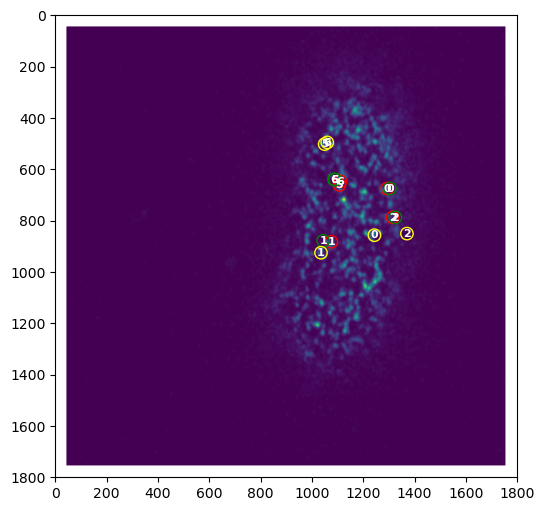

In [145]:
def visualize_error(frame, points_t1, points_t2, ox, oy, dx_gt, dy_gt, dx_pred, dy_pred, overlay_path):
    # Load the background image
    img = mpimg.imread(overlay_path)
        
    img_width = img.shape[0]
    img_height = img.shape[1]

    spatial_scale_x = img_width / frame.shape[0]
    spatial_scale_y = img_height / frame.shape[1]

    diff_x_gt = (dx_gt - ox) * spatial_scale_x
    diff_y_gt = (dy_gt - oy) * spatial_scale_y

    diff_x_pred = (dx_pred - ox) * spatial_scale_x
    diff_y_pred = (dy_pred - oy) * spatial_scale_y

    print(ox)
    print(oy)
    print(dx_gt)
    print(dy_gt)

    print(diff_x_gt)
    print(diff_y_gt)
    print(diff_x_pred)
    print(diff_y_pred)

    ox = ox * spatial_scale_x
    oy = oy * spatial_scale_y

    # Create the plot
    plt.figure(figsize=(6, 6))
    plt.imshow(img, origin='upper', cmap=plt.cm.gray)  # show image with origin at top-left

    # Plot velocity vectors
    #plt.quiver(ox, oy, ox + diff_x_gt, oy + diff_y_gt, color='#bef264', angles='xy', scale_units='xy')
    #plt.quiver(ox, oy, ox + 100, oy + 10, color='#fde047', angles='xy', scale_units='xy')

    # Plot the points of frame 
    plt.scatter(ox, oy, facecolors='none', edgecolors='red', s=80)
    plt.scatter(ox + diff_x_gt, oy + diff_y_gt, facecolors='none', edgecolors='green', s=80)
    plt.scatter(ox + diff_x_pred, oy + diff_y_pred, facecolors='none', edgecolors='yellow', s=80)

    for x, y, gt_x, gt_y, pred_x, pred_y, pid in zip(ox, oy, ox + diff_x_gt, oy + diff_y_gt, ox + diff_x_pred, oy + diff_y_pred, points_t1['point_id']):
        plt.text(
            x, y, str(pid),
            color='white',
            fontsize=8,
            ha='center',
            va='center',
            weight='bold'
        )

        plt.text(
            gt_x, gt_y, str(pid),
            color='white',
            fontsize=8,
            ha='center',
            va='center',
            weight='bold'
        )

        plt.text(
            pred_x, pred_y, str(pid),
            color='white',
            fontsize=8,
            ha='center',
            va='center',
            weight='bold'
        )



    # Adjust plot limits to match the image
    plt.xlim(0, img.shape[1])
    plt.ylim(img.shape[0], 0)  # invert y-axis to match image coordinates
    plt.show()

visualize_error(frame_a, points_a, points_b, points_ax, points_ay, gt_updated_ax, gt_updated_ay, predict_updated_x, predict_updated_y, 'opiv_template.png')